## Compare weighted vote to (naive) majority vote

In [9]:
import os
import sys
curr_dir = os.getcwd()
sys.path.append(os.path.dirname(curr_dir))

import pandas as pd
import numpy as np
import logging
# from sentiment.logger import logger_init

from sentiment.models.sentiment_models import Sentiment_models


In [ ]:
# Read file
filepath = os.path.dirname(curr_dir)
filename = "data/sentiment140.csv"
df = pd.read_csv(os.path.join(filepath, filename), error_bad_lines=False, sep=';')

# Get verbatims
verbatims = df.text.to_list()

In [11]:
# Run predictions
S = Sentiment_models(verbatims)
sentiments, scores = S.get_predictions()

Some weights of the model checkpoint at VictorSanh/roberta-base-finetuned-yelp-polarity were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/mnt/c/Users/fcommo/Documents/Travaux_perso/Python/NLP/Sentiment/sentiment/models/sentiment_models.py:233: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [48]:
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

In [45]:
def accuracy(observed, fitted):
    return np.mean(observed == fitted)

In [20]:
labels = df['label']
features = sentiments.iloc[:,:-1]

# 1. INSTANTIATE
encoder = preprocessing.OneHotEncoder()

# 2. FIT
encoder.fit(features)

# 3. Transform
onehotlabels = encoder.transform(features).toarray()

0      positive
1      positive
2      positive
3      positive
4      positive
         ...   
492     neutral
493    negative
494    positive
495    negative
496    negative
Name: label, Length: 497, dtype: object

In [66]:
# Split in train/test sets
X_train, X_test, y_train, y_test = train_test_split(onehotlabels, labels, test_size=0.33, random_state=42)

# Train
clf = LogisticRegression(random_state=0).fit(X_train, y_train)

# Predict
weighted_predictions = clf.predict(X_test)

# Get model weights
D = dict(zip(clf.classes_, clf.coef_))
D

{'negative': array([ 0.07116554, -0.19015075,  0.11877124,  0.21139105, -0.21160502,
         0.14969629, -0.14991027,  0.56346838, -0.56368235,  1.16279359,
        -0.69215589, -0.47085168, -0.12948429,  0.11529424,  0.01397608]),
 'neutral': array([-0.15416869,  0.43141089, -0.27741573,  0.0323404 , -0.03251393,
         0.09396026, -0.09413379, -0.16849479,  0.16832126, -0.8373659 ,
         1.32200653, -0.48481415, -0.0331421 ,  0.25113992, -0.21817135]),
 'positive': array([ 0.08300315, -0.24126014,  0.15864449, -0.24373146,  0.24411895,
        -0.24365655,  0.24404405, -0.39497359,  0.39536109, -0.32542769,
        -0.62985064,  0.95566583,  0.16262639, -0.36643416,  0.20419527])}

In [85]:
clf.coef_.reshape(-1, 3)

array([[ 0.07116554, -0.19015075,  0.11877124],
       [ 0.21139105, -0.21160502,  0.14969629],
       [-0.14991027,  0.56346838, -0.56368235],
       [ 1.16279359, -0.69215589, -0.47085168],
       [-0.12948429,  0.11529424,  0.01397608],
       [-0.15416869,  0.43141089, -0.27741573],
       [ 0.0323404 , -0.03251393,  0.09396026],
       [-0.09413379, -0.16849479,  0.16832126],
       [-0.8373659 ,  1.32200653, -0.48481415],
       [-0.0331421 ,  0.25113992, -0.21817135],
       [ 0.08300315, -0.24126014,  0.15864449],
       [-0.24373146,  0.24411895, -0.24365655],
       [ 0.24404405, -0.39497359,  0.39536109],
       [-0.32542769, -0.62985064,  0.95566583],
       [ 0.16262639, -0.36643416,  0.20419527]])

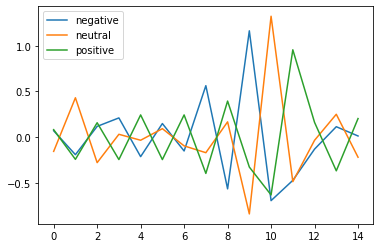

['textblob_label_negative', 'textblob_label_neutral', 'textblob_label_positive']
['flair_label_negative', 'flair_label_positive']
['distilbert_label_negative', 'distilbert_label_positive']
['roberta_label_negative', 'roberta_label_positive']
['twitter_label_negative', 'twitter_label_neutral', 'twitter_label_positive']
['bert_label_negative', 'bert_label_neutral', 'bert_label_positive']


In [82]:
import matplotlib.pyplot as plt

for k, v in D.items():
    plt.plot(v)
    
plt.legend(D.keys())
plt.show()

Z = zip(features.columns, encoder.categories_)
for z in Z:
    print([f"{z[0]}_{z1}" for z1 in z[1]])

In [56]:
# Show weighted vote results
print(accuracy(weighted_predictions, y_test))
print(f1_score(weighted_predictions, y_test, average=None))

pd.crosstab(weighted_predictions, y_test, rownames=['Predicted'], colnames=['Truth'])

0.793939393939394
[0.82222222 0.73469388 0.81690141]


Truth,negative,neutral,positive
Predicted,,,
negative,37,4,2
neutral,4,36,9
positive,6,9,58


In [57]:
# Show majority vote results

maj_vote = sentiments['majority vote']

print(accuracy(maj_vote[y_test.index], y_test))
print(f1_score(maj_vote[y_test.index], y_test, average=None))

pd.crosstab(maj_vote[y_test.index], y_test, rownames=['Predicted'], colnames=['Truth'])


0.7151515151515152
[0.71153846 0.53846154 0.81081081]


Truth,negative,neutral,positive
Predicted,,,
negative,37,15,5
neutral,4,21,4
positive,6,13,60
